In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
%load_ext sql
%sql postgresql://localhost:5432/grav_29_1
%sql create extension if not exists postgis
%sql

 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1


In [3]:
# plotting modules
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=0) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=0)
    return raster

def spectrum(raster, gammas, dgamma = 1.0):
    rasters = []
    for g in gammas:
        print (g,". ", end = '')
        _raster = raster_filter_range(raster, g-dgamma/2, g+dgamma/2)
        rasters.append(_raster)
    return rasters

## Parameters

In [5]:
# Gaussian filter sigma, km
sigmaskm = np.linspace(25,1425,29)
sigmaskm

array([  25.,   75.,  125.,  175.,  225.,  275.,  325.,  375.,  425.,
        475.,  525.,  575.,  625.,  675.,  725.,  775.,  825.,  875.,
        925.,  975., 1025., 1075., 1125., 1175., 1225., 1275., 1325.,
       1375., 1425.])

## Raster from file

In [6]:
# GEBCO_2019.15min.nc is reduced GEBCO_2019.nc dataset
da = xr.open_dataarray('GEBCO_2019.15min.nc').squeeze(drop=True)
da

<xarray.DataArray 'elevation' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:           Elevation relative to sea level
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       height_above_reference_ellipsoid
    units:               m

## Raster to Database

In [7]:
%%time
da.to_dataframe(name='z').to_csv('data.csv', header=False)

CPU times: user 3.02 s, sys: 177 ms, total: 3.2 s
Wall time: 3.62 s


In [8]:
fname = !pwd
fname = fname[0] + '/data.csv'

In [9]:
%%time
%%sql

create extension if not exists postgis;
drop table if exists data;
create table data (lat float, lon float, z float, the_geom geography(Point, 4326));
COPY data (lat, lon, z) FROM :fname WITH DELIMITER ',';
UPDATE data SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX data_the_geom_idx ON data USING GIST (the_geom);
ANALYZE data;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.
Done.
1036800 rows affected.
1036800 rows affected.
Done.
Done.
CPU times: user 21.6 ms, sys: 8.42 ms, total: 30.1 ms
Wall time: 19.4 s


[]

## Grid to Database

In [10]:
grid = da[::150,::150]
print (grid.shape[0]*grid.shape[1])
grid

50


<xarray.DataArray 'elevation' (lat: 5, lon: 10)>
array([[ 2805.0588  ,  2797.1538  ,  2788.7703  ,  2783.9937  ,  2789.0195  ,
         2803.2104  ,  2818.7153  ,  2824.908   ,  2822.3848  ,  2811.987   ],
       [-5086.245   , -3070.7808  , -4268.0107  ,   -83.09523 , -2583.5671  ,
        -3655.863   , -3167.796   , -4288.536   , -3869.2168  , -4229.5996  ],
       [-2500.3286  , -2744.067   , -3929.7122  ,   351.40244 , -5161.817   ,
        -4976.954   , -3243.7595  , -4918.477   , -1740.4358  , -2974.047   ],
       [-5365.9053  , -5340.63    ,  1261.5225  , -5577.9136  , -5515.9976  ,
          893.67267 ,   797.7157  ,   406.9157  ,  -193.5919  , -5435.113   ],
       [-2168.0571  ,   367.64948 ,   428.83673 ,  -110.66021 , -1463.6254  ,
         1248.1346  ,   168.99744 ,    87.563675,   274.6312  ,  -183.86981 ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.88 -52.38 -14.88 22.62 60.12
  * lon      (lon) float64 -179.9 -142.4 -104.9 -67.38 ... 82.62 120.1 157.6
Attributes:
    long_name:           Elevation relative to sea level
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       height_above_reference_ellipsoid
    units:               m

In [11]:
grid.to_dataframe(name='z0').to_csv('grid.csv', header=False)

In [12]:
fname = !pwd
fname = fname[0] + '/grid.csv'

In [13]:
%%time
%%sql

drop table if exists grid;
create table grid (lat float, lon float, z0 float, the_geom geography(Point, 4326));
COPY grid (lat, lon, z0) FROM :fname WITH DELIMITER ',';
UPDATE grid SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX grid_the_geom_idx ON grid USING GIST (the_geom);
ANALYZE grid;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.
50 rows affected.
50 rows affected.
Done.
Done.
CPU times: user 13.7 ms, sys: 5.79 ms, total: 19.5 ms
Wall time: 70.4 ms


[]

## Gaussian Filtering in Database

In [14]:
%%sql

DROP FUNCTION IF EXISTS gaussian_transform(sigma float, geom geography);
CREATE OR REPLACE FUNCTION gaussian_transform(sigma float, geom geography)
    RETURNS TABLE (z float, count bigint)
    AS '
with weights as (
    select
        z,
        exp(-(pow(ST_Distance($2,the_geom,false),2))/(2*pow($1,2))) as weight
    from data
    where ST_Buffer($2,4.*$1) && the_geom and ST_DWithin($2, the_geom, 4.*$1)
)
select
    sum(z*weight)/sum(weight) as z,
    count(1) as count
from weights
'
LANGUAGE SQL STABLE;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.


[]

In [15]:
%%time

%sql drop table if exists gaussian_transform;
%sql create table gaussian_transform (sigmakm int, lat float, lon float, z0 float, z float, count bigint);

for sigmakm in sigmaskm:
    print ("sigmakm", sigmakm)
    %sql insert into gaussian_transform \
         select :sigmakm, lat, lon, z0, t.* from grid, gaussian_transform(:sigmakm*1000, the_geom) as t;

 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1
Done.
sigmakm 25.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 75.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 125.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 175.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 225.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 275.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 325.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 375.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 425.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 475.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 525.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 575.0
 * postgresql://localhost:5432/grav_29_1
50 rows affected.
sigmakm 625.0
 * postgresql://lo

## Show Gaussian Transform map

In [16]:
%sql gaussian << select * from gaussian_transform

 * postgresql://localhost:5432/grav_29_1
1450 rows affected.
Returning data to local variable gaussian


In [17]:
gaussian = gaussian.DataFrame()

In [18]:
gaussian = gaussian.set_index(['sigmakm','lat','lon']).to_xarray()
gaussian

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 10, sigmakm: 29)
Coordinates:
  * sigmakm  (sigmakm) int64 25 75 125 175 225 275 ... 1225 1275 1325 1375 1425
  * lat      (lat) float64 -89.88 -52.38 -14.88 22.62 60.12
  * lon      (lon) float64 -179.9 -142.4 -104.9 -67.38 ... 82.62 120.1 157.6
Data variables:
    z0       (sigmakm, lat, lon) float64 2.805e+03 2.797e+03 ... 274.6 -183.9
    z        (sigmakm, lat, lon) float64 2.821e+03 2.814e+03 ... -1.238e+03
    count    (sigmakm, lat, lon) int64 5083 5083 5083 ... 269196 269643 269424

In [19]:
%%time
# discrete power spectrum
power_spectrum = gaussian.std(['lat','lon'])['z'].rename('spectrum')

CPU times: user 3.58 ms, sys: 2.46 ms, total: 6.04 ms
Wall time: 6.31 ms


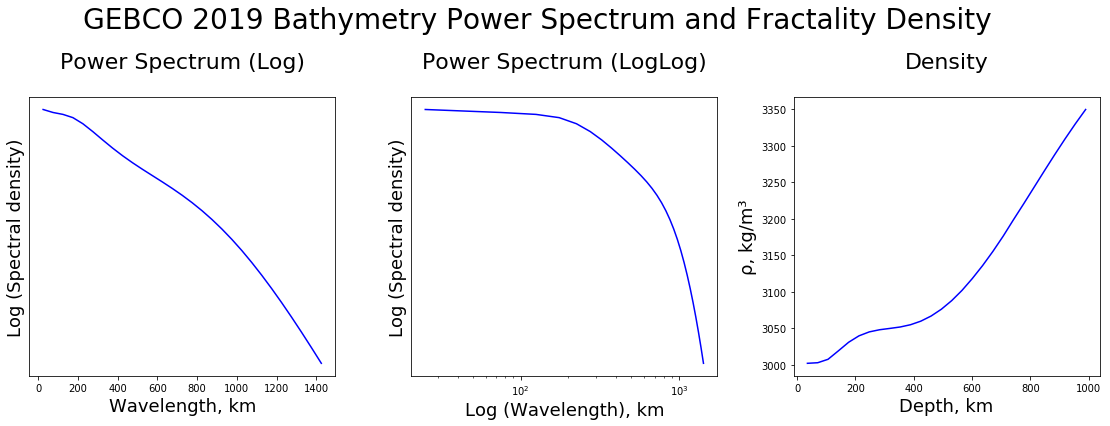

In [20]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1, 3, 1)
ax.plot(power_spectrum.sigmakm.values, power_spectrum.values, c='blue')
ax.set_yscale('log')
ax.set_title(f'Power Spectrum (Log)\n', fontsize=22)
ax.set_ylabel('Log (Spectral density)',fontsize=18)
ax.set_xlabel('Wavelength, km', fontsize=18)
ax.set_yticks([])
ax.set_yticks([], minor=True)

ax = fig.add_subplot(1, 3, 2)
ax.plot(power_spectrum.sigmakm.values, power_spectrum.values, c='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'Power Spectrum (LogLog)\n', fontsize=22)
ax.set_ylabel('Log (Spectral density)',fontsize=18)
ax.set_xlabel('Log (Wavelength), km', fontsize=18)
ax.set_yticks([])
ax.set_yticks([], minor=True)

ax = fig.add_subplot(1, 3, 3)
# calculate fractality index
slope = np.diff(np.log10(power_spectrum))/np.diff(np.log10(power_spectrum.sigmakm))
depths = (power_spectrum.sigmakm.values[1:]+power_spectrum.sigmakm.values[:-1])/2/np.sqrt(2)
fractal = (3 - (slope/2))
ax.plot(depths, 1000*fractal, c='blue')
ax.set_title(f'Density\n', fontsize=22)
ax.set_ylabel('ρ, kg/m³',fontsize=18)
ax.set_xlabel('Depth, km', fontsize=18)

plt.suptitle('GEBCO 2019 Bathymetry Power Spectrum and Fractality Density', fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('Spectral Components Analysis [GEBCO 2019].jpg', dpi=150, quality=95)
plt.show()